## Data connection


In [2]:
import pandas as pd
from pymongo import MongoClient
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Connect to MongoDB
client = MongoClient("mongodb://mongodb:27017/")
db = client.stock_database
collection = db.prices

# 2. Fetch data with the correct asset name
asset_name = "BTC-USD"
cursor = collection.find({"asset": asset_name}).sort("Date", 1)
df = pd.DataFrame(list(cursor))

# 3. Validation check
if df.empty:
    print(f"--- ERROR: No data found for {asset_name} ---")
else:
    print(f"--- SUCCESS: Loaded {len(df)} records for {asset_name} ---")
    df['Date'] = pd.to_datetime(df['Date'])
    df['Month'] = df['Date'].dt.month
    df['DayNum'] = range(len(df))

--- SUCCESS: Loaded 364 records for BTC-USD ---


## Feature Engineering

In [ ]:
# Create lag features for the model
df_btc = df.copy()
df_btc['Price_Yesterday'] = df_btc['Close'].shift(1)
df_btc['Vol_Yesterday'] = df_btc['Volume'].shift(1)
df_btc['Price_Avg_5d'] = df_btc['Close'].rolling(window=5).mean().shift(1)
df_btc['Price_Range'] = (df_btc['High'] - df_btc['Low']).shift(1)

# Remove empty rows created by shifting
df_btc = df_btc.dropna()

# Define feature columns for SVR
features = ['DayNum', 'Price_Yesterday', 'Vol_Yesterday', 'Price_Avg_5d', 'Price_Range']
print(f"Features created: {features}")

## Adaptive Learning

In [4]:
# Split data into training (Jan-Feb) and testing (March)
train_data = df_btc[df_btc['Month'] <= 2]
test_data = df_btc[df_btc['Month'] == 3].copy()

results = []

print("Starting adaptive training loop for March...")

for i in range(len(test_data)):
    # Combine history with already predicted days of March
    current_train = pd.concat([train_data, test_data.iloc[:i]])
    
    # Scale features (Standardization)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(current_train[features])
    X_test_day = scaler.transform(test_data.iloc[[i]][features])
    
    # Train SVR - Using aggressive C for high volatility
    model = SVR(kernel='rbf', C=1000, gamma=0.01)
    model.fit(X_train_scaled, current_train['Close'])
    
    # Predict today's price
    prediction = model.predict(X_test_day)
    results.append(prediction[0])

test_data['Predictions'] = results
print("Training finished!")

Starting adaptive training loop for March...
Training finished!


## MAE MAPE


In [5]:
# Calculate metrics
mae = mean_absolute_error(test_data['Close'], test_data['Predictions'])
mape = mean_absolute_percentage_error(test_data['Close'], test_data['Predictions'])

print(f"--- FINAL BTC ANALYSIS ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} USD")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")

--- FINAL BTC ANALYSIS ---
Mean Absolute Error (MAE): 7598.64 USD
Mean Absolute Percentage Error (MAPE): 9.05%


## Visualisations


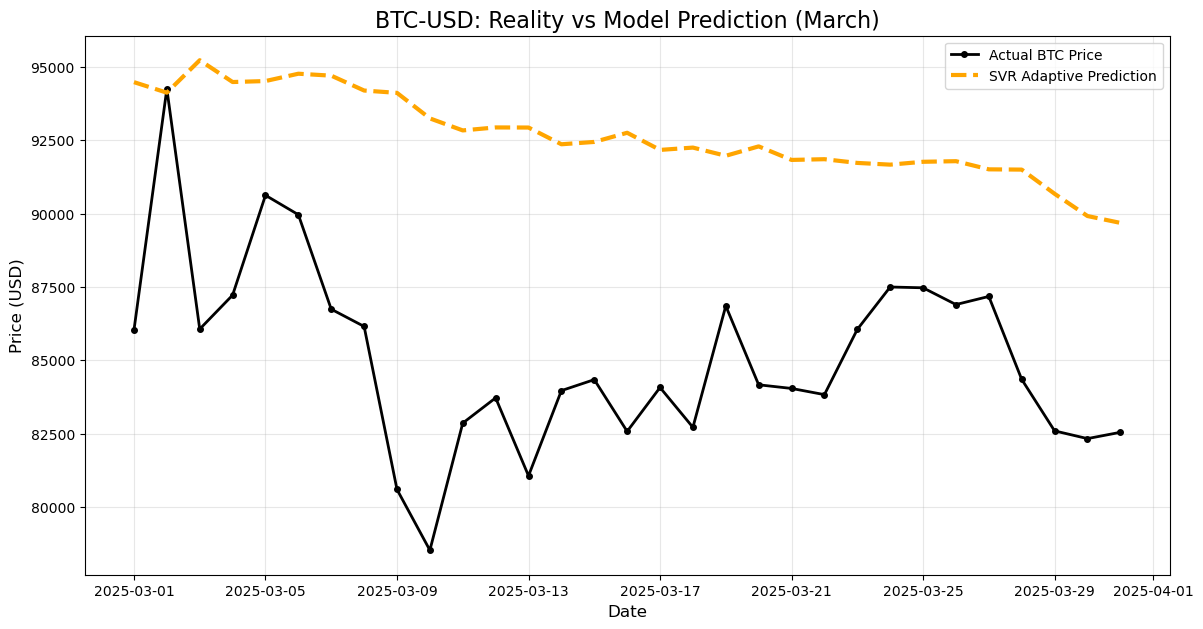

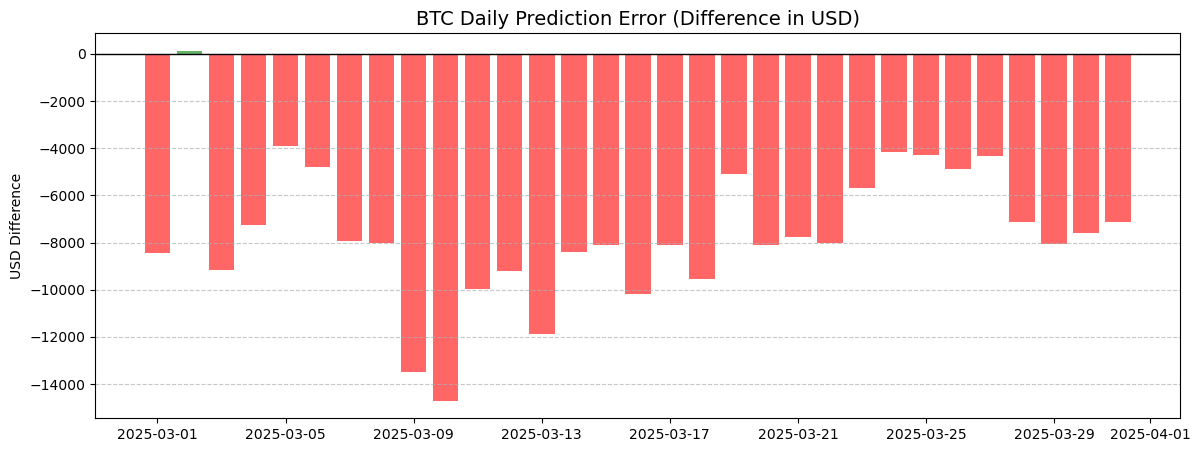

--- DETAILED ERROR ANALYSIS ---
Biggest undershot (Real > Pred): 129.37 USD
Biggest overshot (Pred > Real): -14710.38 USD


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- VISUALIZATION BTC ---

# 1. Main Price Chart (Real vs Predicted)
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'], test_data['Close'], color='black', label='Actual BTC Price', linewidth=2, marker='o', markersize=4)
plt.plot(test_data['Date'], test_data['Predictions'], color='orange', label='SVR Adaptive Prediction', linewidth=3, linestyle='--')

plt.title("BTC-USD: Reality vs Model Prediction (March)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Error Magnitude Chart (How much we missed each day)
test_data['Daily_Diff'] = test_data['Close'] - test_data['Predictions']

plt.figure(figsize=(14, 5))
plt.bar(test_data['Date'], test_data['Daily_Diff'], 
        color=np.where(test_data['Daily_Diff'] > 0, 'green', 'red'), alpha=0.6)

plt.axhline(0, color='black', linewidth=1)
plt.title("BTC Daily Prediction Error (Difference in USD)", fontsize=14)
plt.ylabel("USD Difference")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"--- DETAILED ERROR ANALYSIS ---")
print(f"Biggest undershot (Real > Pred): {test_data['Daily_Diff'].max():.2f} USD")
print(f"Biggest overshot (Pred > Real): {test_data['Daily_Diff'].min():.2f} USD")

## GridSearchCV

In [7]:
import pandas as pd
from pymongo import MongoClient
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 1. Connect and Load BTC-USD
client = MongoClient("mongodb://mongodb:27017/")
db = client.stock_database
collection = db.prices
cursor = collection.find({"asset": "BTC-USD"}).sort("Date", 1)
df_btc = pd.DataFrame(list(cursor))

# 2. Advanced Feature Engineering
df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc['Price_Yesterday'] = df_btc['Close'].shift(1)
df_btc['Vol_Yesterday'] = df_btc['Volume'].shift(1)
df_btc['Price_Range'] = (df_btc['High'] - df_btc['Low']).shift(1)
df_btc['Price_Avg_5d'] = df_btc['Close'].rolling(window=5).mean().shift(1)
df_btc['Month'] = df_btc['Date'].dt.month
df_btc['DayNum'] = range(len(df_btc))
df_btc = df_btc.dropna()

features = ['DayNum', 'Price_Yesterday', 'Vol_Yesterday', 'Price_Range', 'Price_Avg_5d']

# 3. Setup GridSearch Parameters
# We want to check higher C values for Bitcoin's volatility
param_grid = {
    'C': [1000, 5000, 10000], 
    'gamma': [0.01, 0.05, 0.1],
    'epsilon': [0.1, 0.5]
}

# 4. Training and Testing Split
train_data = df_btc[df_btc['Month'] <= 2]
test_data = df_btc[df_btc['Month'] == 3].copy()
results_grid = []

print("Starting GridSearch + Live Loop (this may take a minute)...")

for i in range(len(test_data)):
    # Create rolling window for training
    current_train = pd.concat([train_data, test_data.iloc[:i]])
    
    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(current_train[features])
    X_test_day = scaler.transform(test_data.iloc[[i]][features])
    
    # Run GridSearch for the BEST parameters for this specific day
    # n_jobs=-1 makes it faster by using all CPU cores
    grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, current_train['Close'])
    
    # Predict with the best version of the model
    best_model = grid_search.best_estimator_
    pred = best_model.predict(X_test_day)
    results_grid.append(pred[0])
    
    if i % 5 == 0:
        print(f"Progress: Day {i}/{len(test_data)} | Best C found: {grid_search.best_params_['C']}")

test_data['Grid_Predictions'] = results_grid
print("Search finished!")

# 5. Final Metrics Analysis
mae = mean_absolute_error(test_data['Close'], test_data['Grid_Predictions'])
mape = mean_absolute_percentage_error(test_data['Close'], test_data['Grid_Predictions'])

print(f"\n--- OPTIMIZED BTC ANALYSIS ---")
print(f"Final MAE: {mae:.2f} USD")
print(f"Final MAPE: {mape*100:.2f}%")

Starting GridSearch + Live Loop (this may take a minute)...
Progress: Day 0/31 | Best C found: 10000
Progress: Day 5/31 | Best C found: 10000
Progress: Day 10/31 | Best C found: 10000
Progress: Day 15/31 | Best C found: 10000
Progress: Day 20/31 | Best C found: 10000
Progress: Day 25/31 | Best C found: 10000
Progress: Day 30/31 | Best C found: 10000
Search finished!

--- OPTIMIZED BTC ANALYSIS ---
Final MAE: 2141.23 USD
Final MAPE: 2.53%


## GridSearchCV Visualisations


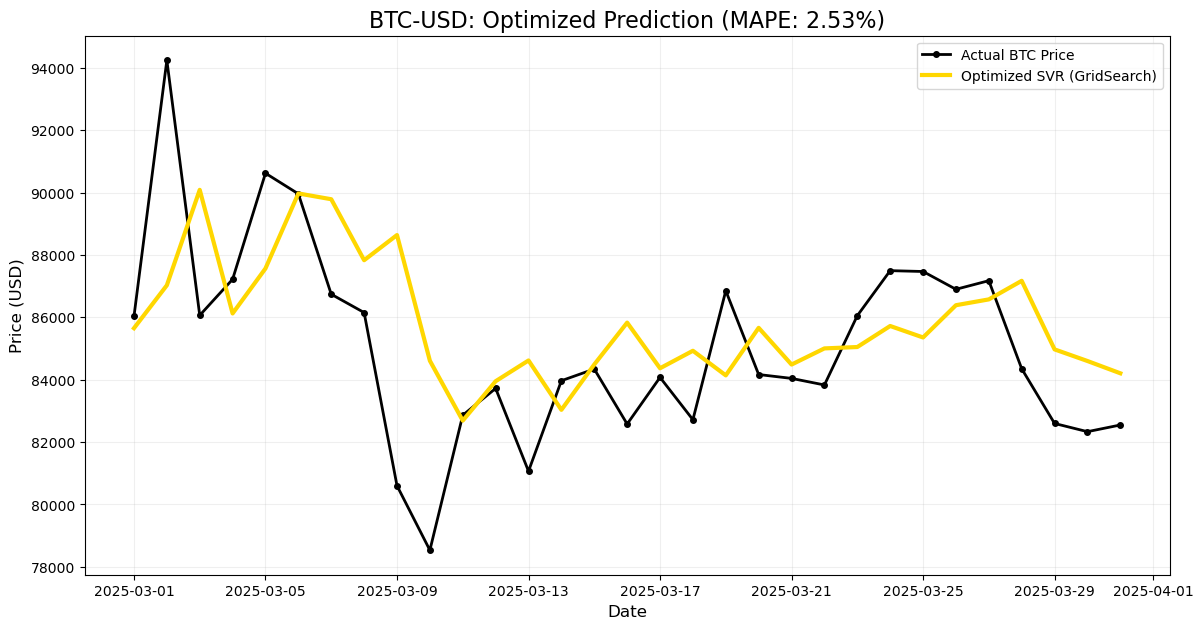

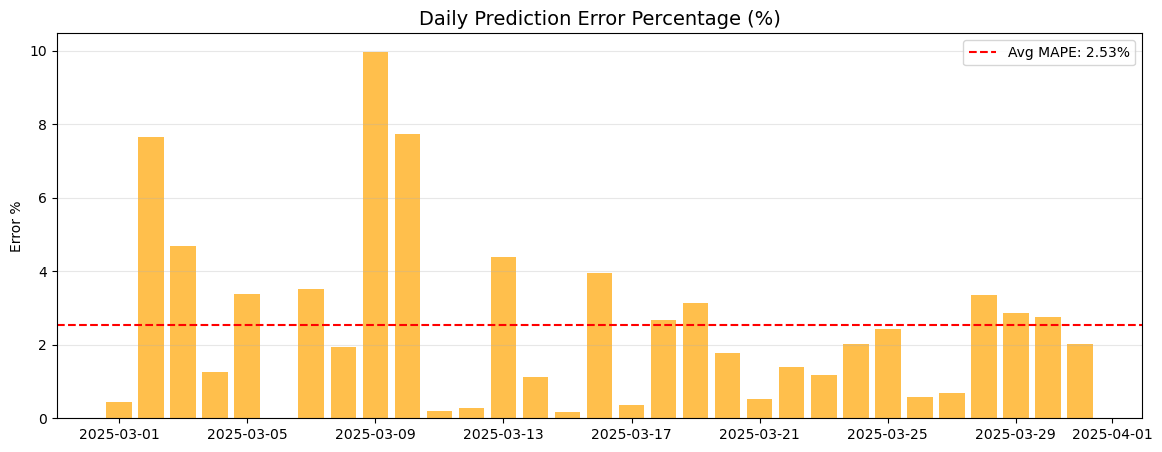

--- VISUALS GENERATED ---
Average accuracy: 97.47%


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- FINAL OPTIMIZED VISUALIZATION ---

# 1. Main Price Chart
plt.figure(figsize=(14, 7))
plt.plot(test_data['Date'], test_data['Close'], color='black', label='Actual BTC Price', linewidth=2, marker='o', markersize=4)
plt.plot(test_data['Date'], test_data['Grid_Predictions'], color='#FFD700', label='Optimized SVR (GridSearch)', linewidth=3)

plt.title(f"BTC-USD: Optimized Prediction (MAPE: {2.53}%)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# 2. Daily Error Percentage Chart
test_data['MAPE_Daily'] = (test_data['Close'] - test_data['Grid_Predictions']).abs() / test_data['Close'] * 100

plt.figure(figsize=(14, 5))
plt.bar(test_data['Date'], test_data['MAPE_Daily'], color='orange', alpha=0.7)
plt.axhline(test_data['MAPE_Daily'].mean(), color='red', linestyle='--', label=f'Avg MAPE: {2.53}%')

plt.title("Daily Prediction Error Percentage (%)", fontsize=14)
plt.ylabel("Error %")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

print("--- VISUALS GENERATED ---")
print(f"Average accuracy: {100 - 2.53:.2f}%")